## Sentiment Analysis Model

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [36]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences

### Data Preprocessing

In [38]:
# Read data

data = pd.read_csv(r'data/review_dataset.csv', encoding='unicode_escape')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
data.shape

(50000, 2)

### Numerify Sentiment Column

In [5]:
sentiment_to_num_dict = {'positive': 1, 'negative': 0}
data['sentiment'] = data['sentiment'].map(sentiment_to_num_dict)
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


### Data Visualization

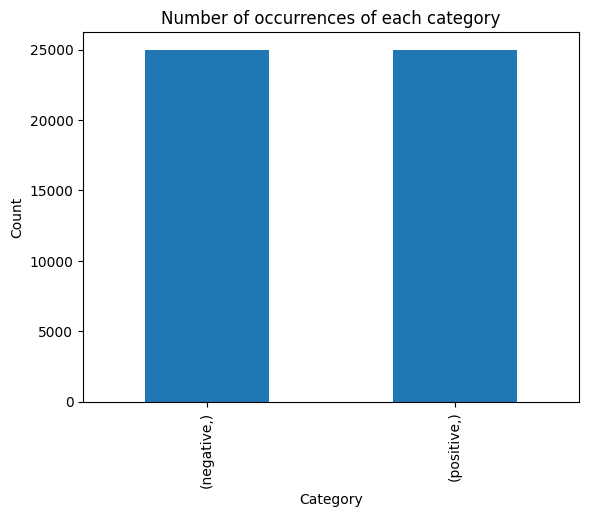

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [39]:
# Visualizing the training set to check for heavy biases

category_counts = data.drop(columns=['review']).value_counts()
category_counts.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Number of occurrences of each category')
plt.show()
data.head()

### More Data Preprocessing

Removing Noise (Numbers, Punctuation Marks, Special Characters, and Whitespaces, and Stop Words) From Text

In [40]:
# Custom preprocessing function

from preprocessing_function import CustomPreprocess

In [8]:
custom = CustomPreprocess()

# Calling custom preprocessing function on data
X = []
sentences = list(data['review'])
for sen in sentences:
    try: 
        X.append(custom.preprocess_text(sen))
    except Exception as error:
        print(f'Error: {error}')
        continue

# Sample processed sentence
print(X[0])

one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skills

### Split Dataset

In [9]:
y = np.array(list(data['sentiment']))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Embedded Layer Preparation

In [10]:
# Convert sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

print([X_train[:5]])

[[[656, 1983, 32, 1723, 1851, 4139, 6264, 652, 4644, 21627, 120, 5949, 18, 635, 25, 3, 1830, 26, 41, 968, 2185, 1030, 330, 417, 762, 281, 28005, 59, 2795, 35554, 4176, 2757, 114, 13, 44, 2960, 126, 309, 96, 4746, 10, 3, 14235, 14, 244, 2, 96, 190, 56765, 39669, 1683, 9850, 38, 295, 45768, 45769, 1515, 11001, 439, 301, 259, 39, 37, 247, 11608, 6601, 243, 12033, 1012, 23694, 56766, 56767, 339, 110, 860, 3982, 75, 315, 555, 483, 127, 34, 700, 113, 305, 246, 6, 3555, 164, 10000, 62, 1536, 87, 11392, 11197, 585, 1767, 1044, 2698, 11198, 3531, 1516, 32471, 121, 100, 207, 919, 2651, 8472, 8963, 3832, 1, 843, 16494, 364, 2429, 136, 15, 32, 32, 553, 9712, 12506, 1197, 119, 4177, 17434, 102, 990, 4199, 5069, 24901, 2138, 45770, 29970, 320, 486, 577, 2775, 1114, 16071, 3430, 59, 1343, 1083, 1449, 732, 1091, 185, 2714, 288, 489, 154, 3373, 845, 13300, 1103, 111, 17435, 113, 3, 89, 1296, 935, 4726, 20778, 28006, 117, 238, 3, 3406, 92, 8003, 729, 3289, 1584, 63, 93, 76, 33, 340, 114, 208, 3290, 1707

In [11]:
import io
import json

In [12]:
# Saving the tokenizer to a json file
tokenizer_json = word_tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [13]:
# Adding 1 to store dimensions for words with no pretrained word embeddings

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92398

In [41]:
# Padding all reviews to length 100

X_train = pad_sequences(X_train, padding='post', maxlen=100)
X_test = pad_sequences(X_test, padding='post', maxlen=100)

In [42]:
from numpy import asarray
from numpy import zeros

In [16]:
# Load GloVe word embeddings to create an embeddings dictionary

embeddings_dictionary = dict()
glove_file = open('glove/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [17]:
# Create embedding matrix

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [18]:
embedding_matrix.shape

(92398, 100)

### Model Training with Convolutional Neural Network

In [19]:
# Use pretrained weights to improve accuracy

model = Sequential(
    [
        Embedding(input_dim=vocab_length, output_dim=100, weights=[embedding_matrix], input_length=100),
        Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.005)),
        GlobalMaxPooling1D(),
        Dense(units=1, activation='sigmoid')
    ]
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [20]:
# Model compilation

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     9,239,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,239,800 (35.25 MB)

 Trainable params: 9,239,800 (35.25 MB)

 Non-trainable params: 0 (0.00 B)

None


In [21]:
model_history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7221 - loss: 0.9035 - val_accuracy: 0.8540 - val_loss: 0.4719
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8761 - loss: 0.4173 - val_accuracy: 0.8634 - val_loss: 0.3995
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9049 - loss: 0.3255 - val_accuracy: 0.8751 - val_loss: 0.3658
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9381 - loss: 0.2597 - val_accuracy: 0.8758 - val_loss: 0.3654
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9672 - loss: 0.1962 - val_accuracy: 0.8677 - val_loss: 0.3806


In [22]:
# Predictions on the testing set

score = model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8728 - loss: 0.3666


In [23]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3711763322353363
Test Accuracy: 0.869700014591217


In [24]:
# Saving the model as an h5 file

model.save(f"./model_acc_{round(score[1], 3)}.h5", save_format='h5')

### Predictions using Model

In [56]:
# Load previously trained CNN Model

from keras.models import load_model

pretrained_model = load_model('model/model_acc_0.87.h5')

# summarize model.
pretrained_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (128, 100, 100)        │     9,239,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (128, 96, 128)         │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (128, 128)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (128, 1)               │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,304,059 (35.49 MB)

 Trainable params: 9,304,057 (35.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [57]:
# Sample reviews

sample_reviews = pd.read_csv('data/test_reviews.csv')

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [58]:
unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = custom.preprocess_text(review)
  unseen_processed.append(review)

In [59]:
unseen_processed

['intelligent movie movie obviously allegorical fascinating tale ai mainly manipulation power wanting action spectacular cgi movie aimed people like think rather passively wait entertained themes ai also surveillance excellent points data us collected phone companies search engine companies commercial operating systems makers plot seems simple extremely clever protagonist playing games trying stay one step ahead one another movie perfectly consistent internal logic plays perfectly go expecting much however see people satisfied movie sets brilliantly therefore give least recent movies getting movie succeeds another recent movie ai transcendence think called failed interesting failure third movie ai spanish movie called eva also brilliant eva moving movie philosophical movies perfect different ways ai name movie ava seems nod title spanish movie aside nice stars appeared ex machina eva casting great course several aspects movie unrealistic often absurd allegorical movie acceptable movie 

In [60]:
from keras_preprocessing.text import tokenizer_from_json

In [61]:
# Loading tokenizer from .json file
with open('tokenizer.json') as f:
    data = json.load(f)
    loaded_tokenizer = tokenizer_from_json(data)

In [63]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = loaded_tokenizer.texts_to_sequences(unseen_processed)

In [64]:
# Pad data
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=100)

In [65]:
# Passing tokenised data to CNN model
unseen_sentiments = pretrained_model.predict(unseen_padded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [66]:
# Displaying model output

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)


dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,4.6
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,0.0
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,0.2
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.7
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.5
